<a href="https://colab.research.google.com/github/aashishpiitk/from-Scratch/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# ! rm -r /content/content

In [ ]:
! unzip -q /content/gdrive/MyDrive/cityscapes_dataset/cityscapes.zip -d /content

In [ ]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

import math
from pathlib import Path
from torchsummary import summary
import torchvision
from PIL import Image, ImageOps

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# number of epochs of training
n_epochs = 50
# name of the dataset
dataset_path = "/content/train/test/"
# size of the batches
batch_size = 2
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of second order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 100
# number of cpu threads to use during batch generation
n_cpu = 8
# high res. image height
hr_height = 64
# high res. image width
hr_width = 64
# number of image channels
channels = 1

# os.makedirs("images", exist_ok=True)
# os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)


In [ ]:
class ImageDataset(Dataset):
  def __init__(self, files):
    #super(ImageDataset, self)

    self.files = files
    self.trans1 = transforms.Compose([transforms.Resize((256,256)),
                               transforms.ToTensor()])
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])
    
    #self.trans2 = transforms.Resize((227,227))

    #self.trans1 = transforms.ToTensor()
  
  def __getitem__(self, index):
    img = self.files[index % len(self.files)][0]
    smnt = self.files[index % len(self.files)][1]
    
    output_dict = {
        'smnt' : self.trans1(smnt),
        'img' : self.trans1(img),
    }

    return output_dict
  
  def __len__(self):
      return len(self.files)


In [ ]:
train_dataset = torchvision.datasets.Cityscapes('/content/content/cityscapes', split='train', mode='fine',
                     target_type='semantic')

train_dataloader = DataLoader(ImageDataset(train_dataset), batch_size=batch_size, shuffle=True, num_workers=n_cpu)


In [ ]:
test_dataset = torchvision.datasets.Cityscapes('/content/content/cityscapes', split='test', mode='fine',
                     target_type='semantic')

test_dataloader = DataLoader(ImageDataset(test_dataset), batch_size=batch_size, shuffle=True, num_workers=n_cpu)

In [ ]:
class Unet_downsample_block(nn.Module):
  def __init__(self, in_channels, out_channels, num_convs=2, isLast=False):
    super(Unet_downsample_block, self).__init__()

    self.num_convs = num_convs
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.isLast = isLast

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding=1, stride=1)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding=1, stride=1)
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)## to decrease the resolution to half
    self.relu = nn.LeakyReLU(negative_slope=0.2)

  def forward(self, x):
    for i in range(self.num_convs):
      if(i==0):
        x = self.conv1(x)
      else:
        x = self.conv2(x)
      x = self.relu(x)
    if(not self.isLast):
      x = self.maxpool(x)
    return x

In [ ]:
class Unet_upsample_block(nn.Module):
  def __init__(self, in_channels, out_channels, num_convs=2, isLast=False):
    super(Unet_upsample_block, self).__init__()

    self.num_convs = num_convs
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.isLast = isLast

    self.conv1 = nn.Conv2d(in_channels, 2*out_channels, kernel_size = 3, padding=1, stride=1)
    self.conv2 = nn.Conv2d(2*out_channels, 2*out_channels, kernel_size = 3, padding=1, stride=1)
    self.up_conv = nn.ConvTranspose2d(2*out_channels, out_channels, kernel_size=2, stride=2)
    #self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)## to decrease the resolution to half
    self.relu = nn.ReLU()

  

  def crop(self, x, encoder_features):
    _, _, H, W = x.shape
    encoder_features = torchvision.transforms.CenterCrop((H, W))(encoder_features)
    return encoder_features

  
  def forward(self, x, encoder_features):
    #print(encoder_features.shape)
    x = torch.cat((x, self.crop(x, encoder_features)), dim=1)
    #print(x.shape, encoder_features.shape)

    for i in range(self.num_convs):
      if(i==0):
        x = self.conv1(x)
      else:
        x = self.conv2(x)
      x = self.relu(x)

    if(not self.isLast):
      x = self.up_conv(x) 
    return x

  

In [ ]:
# conv_arch = [(), ]

In [ ]:
class UNet(nn.Module):
  def __init__(self, in_channels):
    super(UNet, self).__init__()

    self.d1 = Unet_downsample_block(in_channels, 64)
    self.d2 = Unet_downsample_block(64, 128)
    self.d3 = Unet_downsample_block(128, 256)
    self.d4 = Unet_downsample_block(256, 512)
    self.d5 = Unet_downsample_block(512, 1024, isLast=True)

    self.u0 = nn.ConvTranspose2d(1024,512,2,2)
    self.u1 = Unet_upsample_block(1024, 256)
    self.u2 = Unet_upsample_block(512, 128)
    self.u3 = Unet_upsample_block(256, 64)
    self.u4 = Unet_upsample_block(128, 32, isLast=True)
    self.u5 = nn.Conv2d(64, 64, 1, 1)
     

  def forward(self, x):
    x1 = self.d1(x)
    x2 = self.d2(x1)
    x3 = self.d3(x2)
    x4 = self.d4(x3)
    x5 = self.d5(x4)
    #print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
    y1 = self.u0(x5)
    y2 = self.u1(y1, x4)
    y3 = self.u2(y2, x3)
    y4 = self.u3(y3, x2)
    y5 = self.u4(y4, x1)
    output = self.u5(y5)

    return output




In [ ]:
# unet = UNet(1)

In [ ]:
# summary(unet, (3,256,256))

In [ ]:
class Generator_UNet(nn.Module):
  def __init__(self):
    super(Generator_UNet, self).__init__()

    # input image is 3x256x256
    # there will be 8 encoding conv layers
    self.encoder = UNet(1)
    self.conv_layer = nn.Conv2d(64,3,3,1,1)
  
  def forward(self, x):
    return self.conv_layer(self.encoder(x))

In [ ]:
generator = Generator_UNet().to(device)

In [ ]:
summary(generator, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
         LeakyReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
         LeakyReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
Unet_downsample_block-6         [-1, 64, 128, 128]               0
            Conv2d-7        [-1, 128, 128, 128]          73,856
         LeakyReLU-8        [-1, 128, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]         147,584
        LeakyReLU-10        [-1, 128, 128, 128]               0
        MaxPool2d-11          [-1, 128, 64, 64]               0
Unet_downsample_block-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         295,168
        LeakyReLU-14          [-

In [ ]:
class Discriminator_PatchGAN(nn.Module):
  def __init__(self):
    super(Discriminator_PatchGAN, self).__init__()
    
    self.patch_gan = nn.Sequential(nn.Conv2d(3,64,4,2,1),
                                   nn.LeakyReLU(negative_slope=0.2),
                                   nn.Conv2d(64,128,4,2,1),
                                   nn.BatchNorm2d(128),
                                   nn.LeakyReLU(negative_slope=0.2),
                                   nn.Conv2d(128,256,4,2,1),
                                   nn.BatchNorm2d(256),
                                   nn.LeakyReLU(negative_slope=0.2),
                                   nn.Conv2d(256,512,4,1,1),
                                   nn.BatchNorm2d(512),
                                   nn.LeakyReLU(negative_slope=0.2),
                                   nn.Conv2d(512,1,4,1,1),
                                   nn.LeakyReLU(negative_slope=0.2),
                                   )
  def forward(self, x):
    return self.patch_gan(x)



In [ ]:
disc = Discriminator_PatchGAN().to(device)

In [ ]:
summary(disc, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 31, 31]       2,097,664
      BatchNorm2d-10          [-1, 512, 31, 31]           1,024
        LeakyReLU-11          [-1, 512, 31, 31]               0
           Conv2d-12            [-1, 1, 30, 30]           8,193
        LeakyReLU-13            [-1, 1, 30, 30]               0
Total params: 2,766,529
Trainable param

In [ ]:
criterion1 = nn.L1Loss()
criterionGAN = torch.nn.BCEWithLogitsLoss()
optimizerG = torch.optim.Adam(filter(lambda p: p.requires_grad, generator.parameters()), 
                             lr=lr, betas=(b1, b2))

optimizerD = torch.optim.Adam(filter(lambda p: p.requires_grad, disc.parameters()), 
                             lr=lr, betas=(b1, b2))

In [ ]:
# temp1 = torch.zeros(3,1,1,1)
# temp2 = torch.ones(3,1,1,1)
# loss = criterionGAN(temp1, temp2) # prediction, target
# print(loss)
# #print(temp, torch.nn.Sigmoid(temp))

In [ ]:
n_epochs = 20

In [ ]:
# custom weights initialization called on netG and netD

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator.apply(weights_init)
disc.apply(weights_init)

Discriminator_PatchGAN(
  (patch_gan): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
 torch.cuda.empty_cache()

In [ ]:
train_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]
test_counter = [idx*len(test_dataloader.dataset) for idx in range(1, n_epochs+1)]

trainG_losses, trainD_losses = [], []
testG_losses, testD_losses = [], []

for epoch in range(0,n_epochs):

  lossg = 0
  lossd = 0
  tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
  
  for batch_idx, batch in enumerate(tqdm_bar):
    batch_size = batch['smnt'].shape[0]

    optimizerG.zero_grad()
    optimizerD.zero_grad()
    generator.train()
    disc.train()


    input_img = batch['smnt'].to(device)
    output_img = batch['img'].to(device)

    #noise vector
    #latent_z = torch.randn(batch_size, 10, input_img.shape[2], input_img.shape[3])
    
    #input = torch.cat((latent_z, input_img), dim=1)
    
    #labels
    valid = torch.ones((batch_size, 30, 30)).to(device)
    fake = torch.zeros((batch_size, 30, 30)).to(device)

    #generator
    gen_output = generator(input_img)
    disc_output = disc(gen_output)
    lossGAN = criterionGAN(disc_output.squeeze(), fake.squeeze())
    lossL1 = criterion1(gen_output.squeeze(), output_img.squeeze())

    lossG = lossGAN + lossL1*10
    lossG.backward()
    optimizerG.step()


    if((epoch+1)%2 == 0):

    #discriminator
      disc_fake_output = disc(gen_output.detach())
      disc_real_output = disc(output_img)
      real_loss = criterionGAN(disc_real_output.squeeze(), valid.squeeze())
      fake_loss = criterionGAN(disc_fake_output.squeeze(), fake.squeeze())
      
      lossD = (fake_loss+real_loss)/2
      lossD.backward()
      optimizerD.step()

    lossg += lossG.item()
    lossd += lossD.item()
    tqdm_bar.set_postfix(loss_g=lossg/(batch_idx+1), loss_d=lossd/(batch_idx+1))
  
  trainG_losses.append(lossg/len(train_dataloader))
  trainD_losses.append(lossd/len(train_dataloader))

  
  


  # Testing loop
  with torch.no_grad():
    lossg = 0
    lossd = 0
    tqdm_bar = tqdm(test_dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(test_dataloader)))
    
    for batch_idx, batch in enumerate(tqdm_bar):
      batch_size = batch['smnt'].shape[0]
      # optimizerG.zero_grad()
      # optimizerD.zero_grad()
      generator.eval()
      disc.eval()


      input_img = batch['smnt'].to(device)
      output_img = batch['img'].to(device)

      #noise vector
      #latent_z = torch.randn(batch_size, 10, input_img.shape[2], input_img.shape[3])
      
      #input = torch.cat((latent_z, input_img), dim=1)
      
      #labels
      valid = torch.ones((batch_size, 30, 30)).to(device)
      fake = torch.zeros((batch_size, 30, 30)).to(device)

      #generator
      gen_output = generator(input_img)
      disc_output = disc(gen_output)
      lossGAN = criterionGAN(disc_output.squeeze(), fake.squeeze())
      lossL1 = criterion1(gen_output.squeeze(), output_img.squeeze())

      lossG = lossGAN + lossL1
      # lossG.backward()
      # optimizerG.step()



      #discriminator
      disc_fake_output = disc(gen_output.detach())
      disc_real_output = disc(output_img)
      real_loss = criterionGAN(disc_real_output.squeeze(), valid.squeeze())
      fake_loss = criterionGAN(disc_fake_output.squeeze(), fake.squeeze())
      
      lossD = (fake_loss+real_loss)/2
      # lossD.backward()
      # optimizerD.step()

      lossg += lossG.item()
      lossd += lossD.item()
      tqdm_bar.set_postfix(loss_g=lossg/(batch_idx+1), loss_d=lossd/(batch_idx+1))
    
    testG_losses.append(lossg/len(test_dataloader))
    testD_losses.append(lossd/len(test_dataloader))

  if(True):
    torch.save({
          
          'generator' : generator.state_dict(),
          'disc' : disc.state_dict(),
          'optimizerG': optimizerG.state_dict(),
          'optimizerD': optimizerD.state_dict(),
          # 'train_loss' : train_losses[-1],
          # 'test_loss' : test_losses[-1],
          'epoch': epoch+1,
          }, f"/content/drive/MyDrive/pix2pix/checkpt{epoch+1}.pt")

  

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [ ]:
## load the weights till epoch 2
checkpoint = torch.load("/content/drive/MyDrive/pix2pix/checkpt2.pt",map_location=torch.device(device))
generator.load_state_dict(checkpoint['generator'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
iterator = iter(test_dataloader)
batch = next(iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


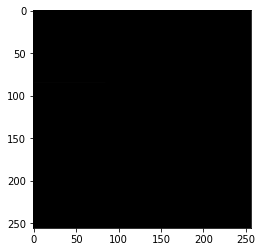

In [ ]:
res = generator(batch['smnt'][1].unsqueeze(0).to(device))
plt.imshow(res.cpu().detach().squeeze().view(256, 256, -1))

In [ ]:
# if(True):
#     torch.save({
          
#           'generator' : generator.state_dict(),
#           'disc' : disc.state_dict(),
#           'optimizerG': optimizerG.state_dict(),
#           'optimizerD': optimizerD.state_dict(),
#           # 'train_loss' : train_losses[-1],
#           # 'test_loss' : test_losses[-1],
#           'epoch': epoch+1,
#           }, f"/content/drive/MyDrive/pix2pix/checkpt{epoch+1}.pt")

In [ ]:
# a = torch.tensor([1,2,3], requires_grad=True, dtype=torch.float32)
# b = torch.tensor([2,3,4], requires_grad=True, dtype=torch.float32)

# c = a+b

# c.backward()

RuntimeError: ignored

In [ ]:
# # resize to 256x256
# # normalize
# transform = transforms.Compose([transforms.Resize((256,256)),
#                                transforms.ToTensor()])
#                               #  transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                               #         std=[0.229, 0.224, 0.225])])

In [ ]:
print(len(train_dataset), type(train_dataset))

2975 <class 'torchvision.datasets.cityscapes.Cityscapes'>


In [ ]:
print(type(train_dataset[0]))

<class 'tuple'>


In [ ]:
## load the data
train_dataset = torchvision.datasets.Cityscapes('/content/cityscapes', split='train', mode='fine',
                     target_type='semantic')

train_dataloader = DataLoader(ImageDataset(train_dataset), batch_size=16, shuffle=True, num_workers=8)
img, smnt = train_dataset[0]


In [ ]:
train_dataloader = DataLoader(ImageDataset(train_dataset), batch_size=16, shuffle=True, num_workers=8)

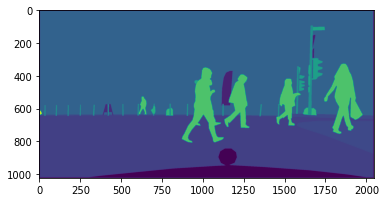

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(smnt)

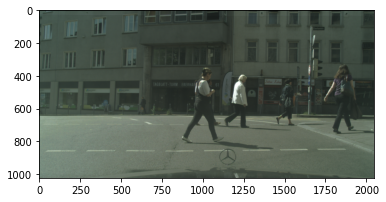

In [ ]:
plt.imshow(img)

In [ ]:
iterator = iter(train_dataloader)
batch = next(iterator)

In [ ]:
print(type(batch['img']))

<class 'torch.Tensor'>


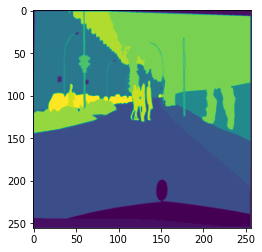

In [ ]:
plt.imshow(batch['smnt'][0].cpu().detach().permute(1,2,0).squeeze())

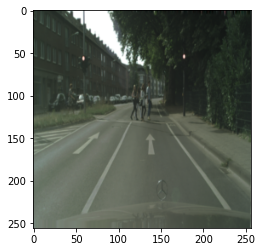

In [ ]:
plt.imshow(batch['img'][0].cpu().detach().permute(1,2,0))

In [ ]:
print(type(batch), batch.size())

In [ ]:
print(transforms.ToTensor()(smnt))

tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0118]]])


In [ ]:
val_dataset = torchvision.datasets.Cityscapes('/content/cityscapes', split='train', mode='fine',
                     target_type='semantic')

In [ ]:
! wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=aashishp&password=googlemailservice&submit=Login' https://www.cityscapes-dataset.com/login/
! wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

--2021-06-17 04:36:01--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2021-06-17 04:36:03--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html’

index.html              [  <=>               ]  43.80K   163KB/s    in 0.3s    

2021-06-17 04:36:04 (163 KB/s) - ‘index.html’ saved [44855]

--2021-06-17 04:36:04--  https://www.cityscapes-dataset.com/file-handling/?packageID=1
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8

In [ ]:
! wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=aashishp&password=googlemailservice&submit=Login' https://www.cityscapes-dataset.com/login/
! wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

--2021-06-17 04:36:39--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2021-06-17 04:36:41--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html.1’

index.html.1            [   <=>              ]  43.80K  82.6KB/s    in 0.5s    

2021-06-17 04:36:42 (82.6 KB/s) - ‘index.html.1’ saved [44855]

--2021-06-17 04:36:42--  https://www.cityscapes-dataset.com/file-handling/?packageID=3
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.

In [ ]:
! unzip /content/leftImg8bit_trainvaltest.zip

Streaming output truncated to the last 5000 lines.
 extracting: leftImg8bit/train/jena/jena_000074_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000040_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000020_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000030_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000005_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000059_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000100_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000034_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000089_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000104_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000107_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000080_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000006_000019_leftImg8bit.png  


In [ ]:
! unzip /content/gtFine_trainvaltest.zip

Streaming output truncated to the last 5000 lines.
  inflating: gtFine/test/berlin/berlin_000117_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000114_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000434_000019_gtFine_labelIds.png  
  inflating: gtFine/test/berlin/berlin_000420_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000483_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000420_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000254_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000490_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000448_000019_gtFine_polygons.json  
  inflating: gtFine/test/berlin/berlin_000099_000019_gtFine_labelIds.png  
  inflating: gtFine/test/berlin/berlin_000068_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000288_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000409_00001

In [ ]:
! mv /content/gtFine /content/cityscapes

In [ ]:
! zip -r /content/gdrive/MyDrive/cityscapes_dataset/cityscapes.zip /content/cityscapes

Streaming output truncated to the last 5000 lines.
  adding: content/cityscapes/gtFine/train/tubingen/tubingen_000136_000019_gtFine_color.png (deflated 62%)
  adding: content/cityscapes/gtFine/train/tubingen/tubingen_000118_000019_gtFine_color.png (deflated 24%)
  adding: content/cityscapes/gtFine/train/tubingen/tubingen_000069_000019_gtFine_labelIds.png (deflated 4%)
  adding: content/cityscapes/gtFine/train/tubingen/tubingen_000140_000019_gtFine_color.png (deflated 23%)
  adding: content/cityscapes/gtFine/train/tubingen/tubingen_000138_000019_gtFine_polygons.json (deflated 94%)
  adding: content/cityscapes/gtFine/train/tubingen/tubingen_000089_000019_gtFine_labelIds.png (deflated 8%)
  adding: content/cityscapes/gtFine/train/tubingen/tubingen_000126_000019_gtFine_instanceIds.png (deflated 12%)
  adding: content/cityscapes/gtFine/train/tubingen/tubingen_000073_000019_gtFine_instanceIds.png (deflated 9%)
  adding: content/cityscapes/gtFine/train/tubingen/tubingen_000101_000019_gtFine_l